In [20]:
import pystan
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
%matplotlib inline

# MindLab Model for shelving
There are three variables that could effect whether an item is selected, `product_index`, `product` and `price`. We want to be able to marginalise out product and price to see effect of shelf position (`product_index`). As there is a binary input from the user, we will use the bernoulli probability distribution as our likelihood function. The bernoulli distribution is a special case of the binomial distribution i.e. when n=1.


$$y_j\sim\mbox{bernoulli}\left( \mbox{logit}^{-1}(f(m_{\alpha_i},\beta_i,c_{\gamma_i}))\right),\mbox{ for } j=1,\dots, J.$$

* $y_{ij}$ is the response for person $j$ to a particular product ($m_{\alpha}$) at a particular price ($\beta_{i}$)   and location on shelf ($c_{i}$) i.e. `fit`=1 or `does not fit`=0
* $m_{\alpha} $ is product (discrete)
* $\beta_i$ is price (continuous)
* $c_{\gamma}$ is position (discrete)



The key is coming up with the function ($f$)

For our first model, we will assume a linear relationship:
$$m_{\alpha}*\beta_{i}+c_{\gamma}$$
where:
* $m$ is slope, telling us how much price affects selection
* $c$ is intercept, telling us how much product position changes selection



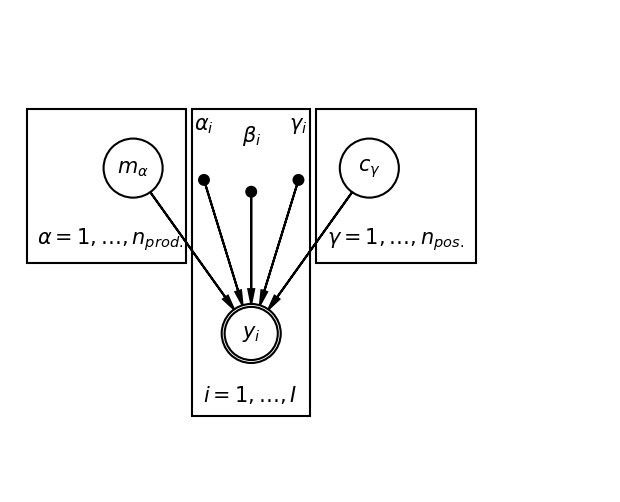

In [2]:
import daft

pgm = daft.PGM(shape=(5,4),observed_style="inner",dpi=150)

pgm.add_node('m',r'$m_{\alpha}$',1,2.7)
pgm.add_node('beta',r'$\beta_i$',2,2.5,fixed=True)
pgm.add_node('c',r'$c_{\gamma}$',3,2.7)
pgm.add_node('y',r'$y_i$',2,1.3,observed=True)
pgm.add_node('alpha',r'$\alpha_i$',1.6,2.6,fixed=True)
pgm.add_node('gamma',r'$\gamma_i$',2.4,2.6,fixed=True)



pgm.add_edge('m','y')
pgm.add_edge('beta','y')
pgm.add_edge('c','y')
pgm.add_edge('gamma','y')
pgm.add_edge('alpha','y')


pgm.add_plate([1.5, 0.7, 1, 2.5], label=r"$i = 1, \ldots, I$", shift=-0.1)
pgm.add_plate([0.1, 2, 1.35, 1.2], label=r"$\alpha = 1, \ldots, n_{prod.}$", shift=-0.1)
pgm.add_plate([2.55, 2, 1.35, 1.2], label=r"$\gamma = 1, \ldots, n_{pos.}$", shift=-0.1)



# Render and save.
pgm.render()
pgm.show()

### Visualing the model

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


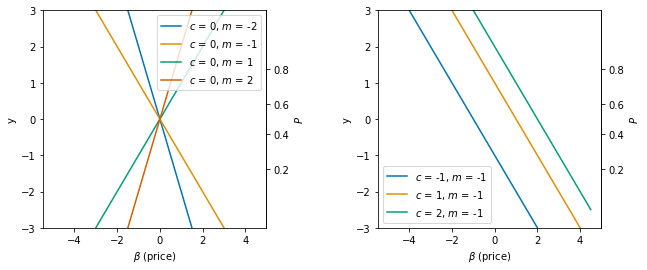

In [25]:
import matplotlib.ticker as ticker

def inv_logit_plot(x):
    return 1/(1+np.exp(-1*(x)))
def logit_plot(x):
    return np.log(x/(1-x))

cmap=sns.color_palette("colorblind")
fig=plt.figure(figsize=(10,4))
x=np.arange(-5,5,0.5)
ax1=fig.add_subplot(1,2,1)

c=0
for i,m in enumerate([-2,-1,1,2]):
    ax1.plot(x,c+m*x,label=r'$c$ = {}, $m$ = {}'.format(c,m),c=cmap[i])

ax1.legend()
ax1.set_xlabel(r'$\beta$ (price)')
ax1.set_ylabel('y')
ax1.set_ylim(-3,3)
secax = ax1.secondary_yaxis('right', functions=(inv_logit_plot, logit_plot))
secax.yaxis.set_minor_locator(AutoMinorLocator())
secax.set_ylabel('$P$')




ax3=fig.add_subplot(1,2,2)
m=-1
for i,c in enumerate([-1,1,2]):
    ax3.plot(x,c+m*x,label=r'$c$ = {}, $m$ = {}'.format(c,m),c=cmap[i])
ax3.set_xlabel(r'$\beta$ (price)')
ax3.set_ylabel('y')
ax3.set_ylim(-3,3)

secax = ax3.secondary_yaxis('right', functions=(inv_logit_plot, logit_plot))
secax.yaxis.set_minor_locator(AutoMinorLocator())
secax.set_ylabel('$P$')

ax3.legend()

plt.subplots_adjust(wspace=0.5)

* a negative $m$ means probability of selection will decrease with price
* a negative $c$ decreases the probability of selection, but does not change the relationship with price. 

## Build the model

In [11]:
model="""
data {
  int<lower=1> K;              // number of product places
  int<lower=1> N;              // number of observations
  vector[N] price;  //product price for observation n
  int<lower=1,upper=K> kk[N];  // product place for observation n
  int<lower=0,upper=1> y[N];   // selected or not for observation n
  int<lower=0> nprice; //number of price points
  vector[nprice] price_pred; //price points for predictions
  int fit;//boolean for fitting
}

parameters {
  vector[K] c;              // effect of place for k
  real m; // slope;
}

model {
  m ~ std_normal();
  c ~ normal(0, 1);
  if (fit > 0){
  y ~ bernoulli_logit(m*price + c[kk]);
  }
}

generated quantities {
vector[N] y_rep;
matrix[nprice,K] pred_matrix;
matrix[nprice,K] pred_matrix_select;

for (i in 1:nprice){
for (j in 1:K){
pred_matrix[i,j]=m*price_pred[i] + c[j];
pred_matrix_select[i,j]=bernoulli_logit_rng(pred_matrix[i,j]);
}
}

if (fit > 0){
for (i in 1:N){
y_rep[i] = bernoulli_logit_rng(m*price[i] + c[kk[i]]);
}
}
}
"""

### Analyse the Generative Ensemble
* Analyse a range of samples from generative model
* Check outputs are realistic
* Good way of checking model (especially priors) is behaving appropriately and how you expect

In [12]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_acd895b4a925f88d2cc6b18d289602c2 NOW.


In [15]:
data={
    'K':5,
    'N':1,
    'price':[0],
    'kk':[1],
    'y':[1],
    'nprice':10,
    'price_pred':np.arange(-5,5,1.0),
    'fit':0
}

In [16]:
fit=sm.sampling(data=data,chains=1,iter=500)

In [17]:
pystan.diagnostics.check_hmc_diagnostics(fit,verbose=3)

INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 1.25) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': False,
 'Rhat': False,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [18]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_acd895b4a925f88d2cc6b18d289602c2.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c[1]                       0.02    0.04   0.92  -1.64  -0.67   0.02   0.67    1.8    441    1.0
c[2]                       0.04    0.07   1.02  -1.91  -0.66   0.02   0.67   2.05    239    1.0
c[3]                      -0.04    0.06   0.97  -1.92   -0.7  -0.11   0.65   2.16    251    1.0
c[4]                      -0.09    0.06    1.0  -2.06  -0.78  -0.08   0.58   1.91    264    1.0
c[5]                      -0.12    0.07   1.02  -2.16  -0.85  -0.01   0.56   1.82    235   1.01
m                         -0.12    0.07   1.08  -2.24  -0.82  -0.16   0.64   2.05    222   1.01
y_rep[1]                    nan     nan    nan    nan    nan    nan    nan    nan    nan    nan
pred_ma

Prior distribution on parameters:

Text(0.5, 0, 'm')

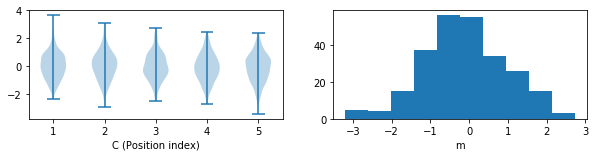

In [26]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.violinplot(fit['c']);
plt.xlabel('C (Position index)')
plt.subplot(1,2,2)
plt.hist(fit['m']);
plt.xlabel('m')

## Prior Predictive distribution
Lets visualise how the chances of selection change with price and position on shelf for some of the samples from our prior predicitive distribution.

The first column shows a heatmap of price vs position. The colours represent the chances of selection before applying the inverse logit transformation.

The second column shows a heatmap of price vs position. The colours some randomly generated data using the bernoulli distribution.

The third column shows the value of $c$ for each place on the shelf. Note how it relates to the colours in the first column.

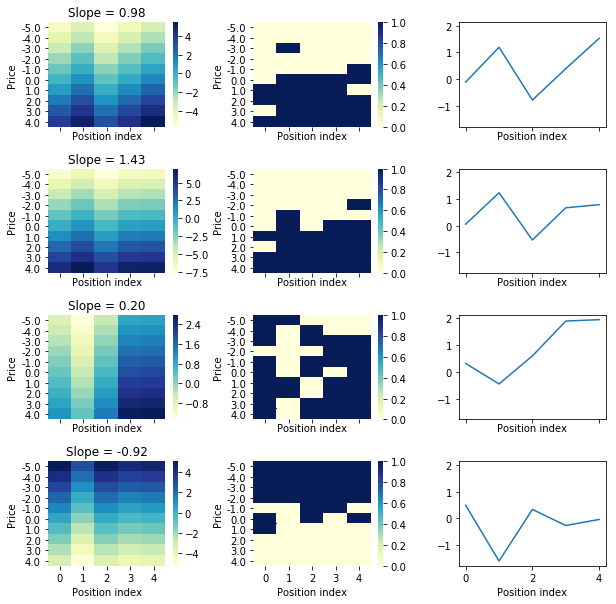

In [79]:
s=[0,1,2,10]
fig, ax = plt.subplots(len(s), 3, sharex='col', sharey='col',figsize=(10,10))

for i in range(0,len(s)):
    sns.heatmap(fit['pred_matrix'][s[i],:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,0],)
    ax[i,0].set_xlabel('Position index')
    ax[i,0].set_ylabel('Price')
    ax[i,0].set_title(r'Slope = {:.2f}'.format(fit['m'][s[i]],fit['c'][s[i]]))
    sns.heatmap(fit['pred_matrix_select'][s[i],:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,1])
    ax[i,1].set_xlabel('Position index')
    ax[i,1].set_ylabel('Price')
    ax[i,2].plot(fit['c'][s[i]])
    ax[i,2].set_xlabel('Position index')
fig.subplots_adjust(hspace=0.4, wspace=0.4)


## Fit prior samples

In [112]:
def zscore(posterior, truth):
    return np.abs((np.mean(posterior)-truth)/np.std(posterior))
def shrinkage(posterior,prior):
    return 1-(np.var(posterior)/np.var(prior))

In [80]:
def get_indicators(N, M, prob_std=0.5):
    ind = np.random.binomial(1, prob_std, (N, M))
    return ind>0

In [124]:
zscore_prior_pred_c=np.empty((fit.data['K'],10))
zscore_prior_pred_m=np.empty((1,10))
shrinkage_prior_pred_c=np.empty((fit.data['K'],10))
shrinkage_prior_pred_m=np.empty((1,10))


for s in range(0,10):
    data_prior={
        'K':fit.data['K'],
        'N':fit['pred_matrix'][s,:,:].flatten().size,
        'price':np.repeat(np.arange(-5,5,1.0),5),
        'kk':np.tile(np.arange(1,6,1),10),
        'y':fit['pred_matrix_select'][s,:,:].flatten().astype(int),
        'nprice':10,
        'price_pred':np.arange(-5,5,1.0),
        'fit':1
    }
    fit_prior=sm.sampling(data=data_prior)
    zscore_prior_pred_c[:,s]=zscore(fit_prior['c'],fit['c'][s,:])
    for i in range(0,fit.data['K']):
        shrinkage_prior_pred_c[i,s]=shrinkage(fit_prior['c'][:,i],fit['c'][:,i])
    zscore_prior_pred_m[0,s]=zscore(fit_prior['m'],fit['m'][s])
    shrinkage_prior_pred_m[0,s]=shrinkage(fit_prior['m'][:],fit['m'][:])

### Analyse Posterior Behaviours

**Z score**
$$z=|(\mu_{post}-\theta_{true})/\sigma_{post}|$$

how accurately the posterior recovers ground truth and whether there is any bias. Close to zero indicate more accurate, less biased posteriors.

**Posterior Shrinkage**
$$s=1-\sigma^2_{post}/\sigma^2_{prior}$$

quantifies how much the posterior learns from a given observation. Close to zero indicates dominated by prior, close to one indicates dominated by data.

<img src="../assets/sensitivity.png" alt="Drawing" style="width: 600px;"/>

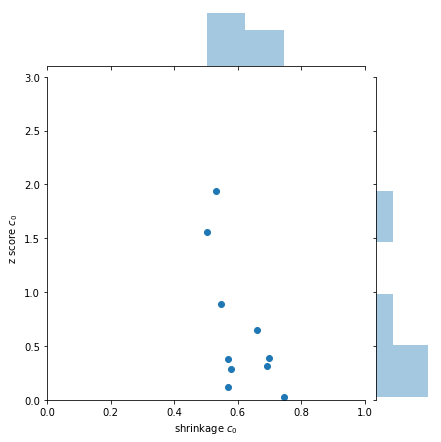

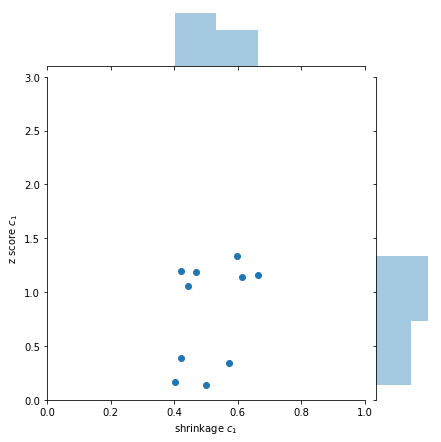

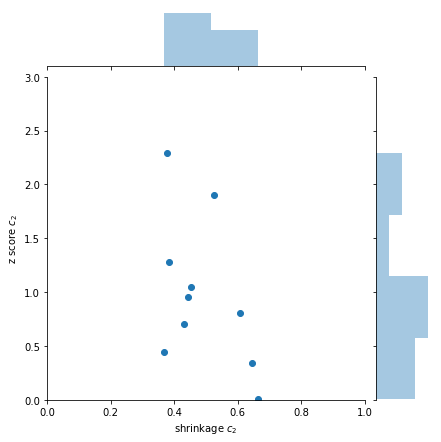

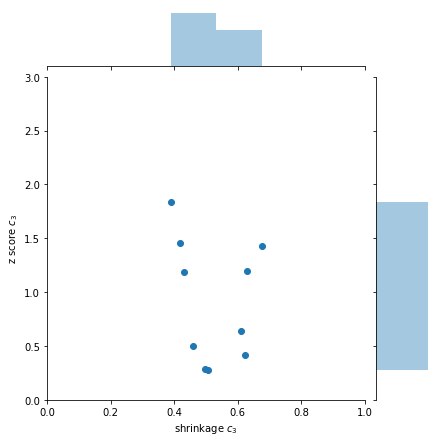

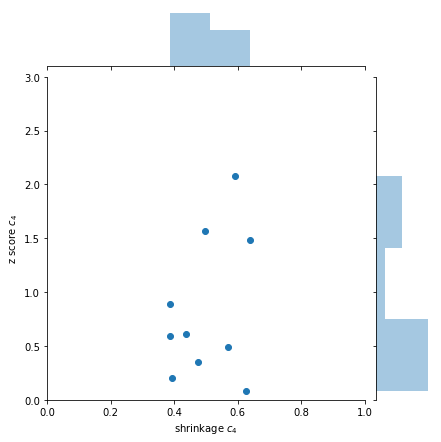

In [141]:
for i in range(0,zscore_prior_pred_c.shape[0]):
    g=sns.jointplot(shrinkage_prior_pred_c[i,:],zscore_prior_pred_c[i,:],xlim=[0,1],ylim=[0,3])
    g.set_axis_labels(r'shrinkage $c_{:4.0f}$'.format(i),r'z score $c_{:4.0f}$'.format(i))

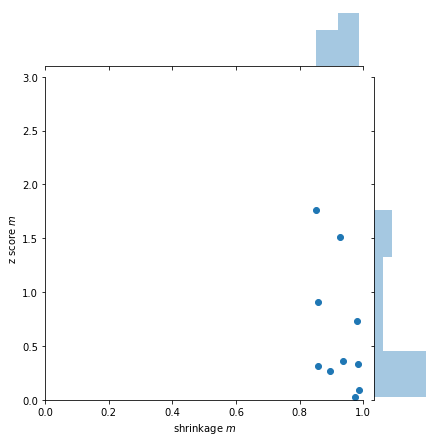

In [143]:
g=sns.jointplot(shrinkage_prior_pred_m[0,:],zscore_prior_pred_m[0,:],xlim=[0,1],ylim=[0,3])
g.set_axis_labels(r'shrinkage $m$'.format(i),r'z score $m$'.format(i))

# Fit model to data
At the moment the model is built for one person and one product. We could assume everyone acts the same as a first pass and fit for every object.

Note we have mean subtracted the price for each product. This makes its easier to fit the model

In [31]:
data=pd.read_csv('../data/raw/priced_shelves_data.csv')
data['id.session_int']=data.groupby('id.session').grouper.group_info[0]+1
data['selected_int']=data.groupby('selected').grouper.group_info[0]
# mean subtract
data['mean_sub_price']=data['price']-data.groupby('product').transform('mean')['price']


In [34]:
ind_product=data['product']==data['product'].unique()[0]

### smirnoff

In [35]:
data_infer={
    'K':data['product_index'].unique().size,
    'N':len(data[ind_product]),
    'price':data[ind_product]['price'],
    'kk':data[ind_product]['product_index'].values+1,
    'y':data[ind_product]['selected_int'],
    'nprice':9,
    'price_pred':np.arange(8,17,1.0),
    'fit':1
}

In [36]:
fit_infer=sm.sampling(data=data_infer)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [38]:
pystan.diagnostics.check_hmc_diagnostics(fit_infer,verbose=3)

INFO:pystan:n_eff / iter looks reasonable for all parameters
INFO:pystan:Rhat looks reasonable for all parameters
INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 1.01) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 2: E-BFMI (= 1.01) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 3: E-BFMI (= 1) equals or exceeds threshold of 0.2.
INFO:pystan:Chain 4: E-BFMI (= 1.04) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

#### Posterior Parameter plots : $c$

[]

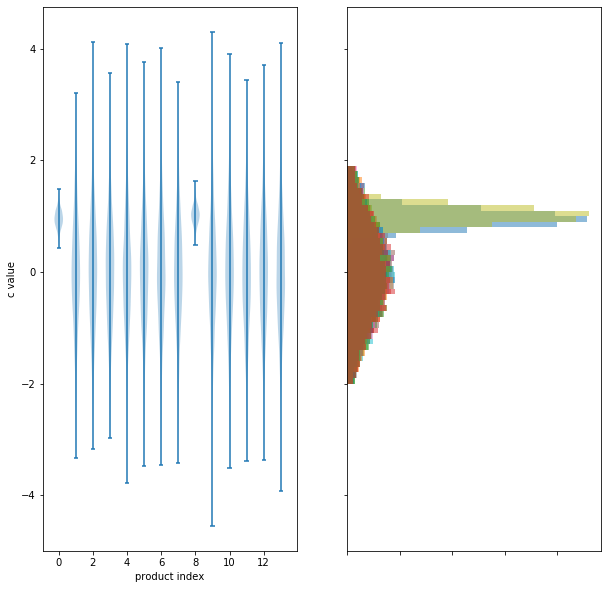

In [45]:
fig, ax = plt.subplots(1, 2, sharey='row',figsize=(10,10))

ax[0].violinplot(fit_infer['c'],positions=data['product_index'].unique());
for i in range(0,fit_infer.data['K']):
    ax[1].hist(fit_infer['c'][:,i],orientation='horizontal',alpha=0.5,bins=np.arange(-2,2,0.1));
ax[0].set_ylabel('c value')
ax[0].set_xlabel('product index')
ax[1].set_xticklabels([])

#### Posterior Parameter plots : $m$

Text(0, 0.5, 'm')

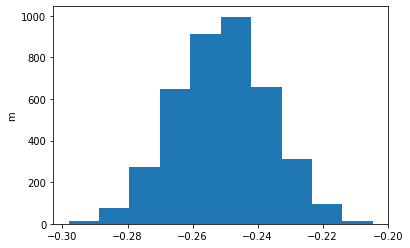

In [49]:
plt.hist(fit_infer['m'])
plt.ylabel('m')

#### Posterior Predictive checks
The only data we have are the selections. We could look at the number of selections as a function of price, and compare to our replicated data,

In [50]:
## work out the the ratio of selections over total

#create empty array with number of positions used and number of unique prices
counts_data=np.empty((np.unique(fit_infer.data['kk']).size,np.unique(fit_infer.data['price'].values).size))
#loop over postion
for i,pi in enumerate(np.unique(fit_infer.data['kk'])):
    #loop over prices
    for j,pri in enumerate(np.unique(fit_infer.data['price'].values)):
        #how many at given position and price
        ind=(fit_infer.data['kk']==pi) & (fit_infer.data['price'].values == pri)
        #how many of those were selected
        ind2=fit_infer.data['y'][ind].values==1
        counts_data[i,j]=ind2.sum()/ind.sum()

In [51]:
#create empty array with number of positions used and number of unique prices
counts_rep=np.empty((fit_infer['y_rep'].shape[0],np.unique(fit_infer.data['kk']).size,np.unique(fit_infer.data['price'].values).size))
#loop over postion
for i,pi in enumerate(np.unique(fit_infer.data['kk'])):
    #loop over prices
    for j,pri in enumerate(np.unique(fit_infer.data['price'].values)):
        #how many at given position and price
        ind=(fit_infer.data['kk']==pi) & (fit_infer.data['price'].values == pri)
        #how many of those were selected
        ind2=fit_infer['y_rep'][:,ind]>0
        counts_rep[:,i,j]=ind2.sum(axis=1)/ind.sum()
    

Text(0, 0.5, 'No. of selected/No. of total')

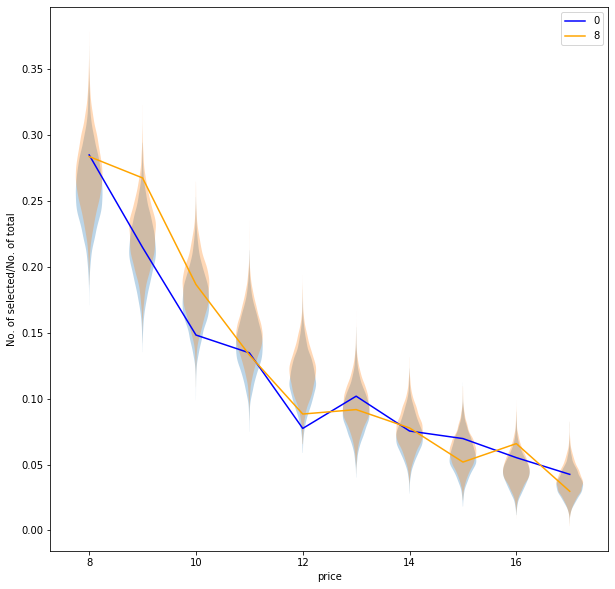

In [52]:
color=['blue','orange']
plt.figure(figsize=(10,10))
plt.violinplot(counts_rep[:,0,:],showextrema=False,positions=np.unique(fit_infer.data['price'].values));
plt.violinplot(counts_rep[:,1,:],showextrema=False,positions=np.unique(fit_infer.data['price'].values));
for i,pi in enumerate(np.unique(fit_infer.data['kk'])):
    plt.plot(np.unique(fit_infer.data['price'].values),counts_data[i,:],color=color[i],label=pi-1)
plt.legend()
plt.xlabel('price')
plt.ylabel('No. of selected/No. of total')

The plot above shows the fraction selected over total for each price and position. The lines are from the data, the violin plots are the distributions for our replicated data. The replicated data distribution shows the uncertianty our model has in the fraction. If our model is doing a good job, the lines should roughly fall within the distributions. They do.

### Look at residuals

Text(0.5, 0, 'price')

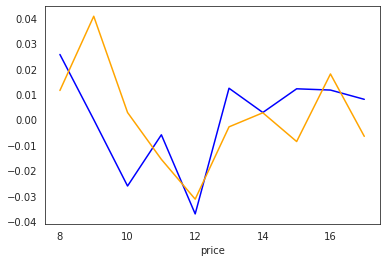

In [60]:
for i,pi in enumerate(np.unique(fit_infer.data['kk'])):
    plt.plot(np.unique(fit_infer.data['price'].values),counts_data[i,:]-np.median(counts_rep[:,i,:],axis=0),color=color[i],label=pi-1)
plt.xlabel('price')

### Bayesian P values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':


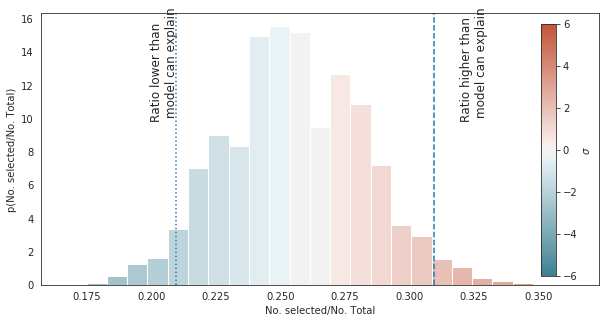

In [53]:
import seaborn as sns
import matplotlib as mpl
sns.set_style("white")

fig=plt.figure(figsize=(10,5))


# This is  the colormap I'd like to use.
cm = sns.diverging_palette(220, 20, as_cmap=True)

# Get the histogramp
Y,X = np.histogram(counts_rep[:,0,0], 25, normed=1)
#C = [cm(((x-X.min())/x_span)) for x in X]
C = [cm(((((x-np.mean(counts_rep[:,0,0]))/np.std(counts_rep[:,0,0]))+6)/12.0)) for x in X]


plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
plt.xlabel('No. selected/No. Total')
plt.ylabel('p(No. selected/No. Total)')
plt.axvline(np.mean(counts_rep[:,0,0])+0.05, linestyle='--')
plt.axvline(np.mean(counts_rep[:,0,0])-0.05,linestyle=':')
plt.annotate('Ratio higher than \n model can explain',xy=(np.mean(counts_rep[:,0,0])+0.06, 5),  xycoords='data',
            xytext=(np.mean(counts_rep[:,0,0])+0.06, 10), textcoords='data',rotation='vertical',size='large')
plt.annotate('Ratio lower than \n model can explain',xy=(np.mean(counts_rep[:,0,0])-0.06, 5),  xycoords='data',
            xytext=(np.mean(counts_rep[:,0,0])-0.06, 10), textcoords='data',rotation='vertical',size='large')

#ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
ax1 = fig.add_axes([0.82, 0.15, 0.02, 0.7])

norm = mpl.colors.Normalize(vmin=-6, vmax=6)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('$\sigma$')

As well as carrying out posterior predictive checks visually, we can quantify the fit with something called a Bayesian P value.

We can calculate fraction of $y_{rep}$ samples above and below real ratio. This is often referred to as the Bayesian P-value and is telling us what the probability is of drawing the real ratio, from our model which has been inferred on the data. This is tells us if the model is inconsistent with the data, given the uncertianties in parameters and data.

* ∼0.5 (i.e. near the middle of the distribution) means our model is consistent with the data
* 0.99 or 0.01 (i.e. in the tails) means the model is missing something.

We can convert this to a typical '$\sigma$' level, such that $\sigma<−3$ or $\sigma>3$ indicates a problem with the model.

For more information on posterior predictive checks, see:


Bayesian Data Analysis
http://www.stat.columbia.edu/~gelman/research/published/philosophy.pdf

In [54]:
def Bayes_P_value(rep_data,obs_data):
    import scipy.stats as st
    pval=np.empty_like(obs_data)
    for i,d in enumerate(obs_data):
        ind=rep_data[:,i]<d
        pval[i]=st.norm.ppf(sum(ind)/rep_data.shape[0])
    return pval

In [55]:
pvalues=Bayes_P_value(counts_rep,counts_data)

In [56]:
print(pvalues)

[[ 0.87974032 -0.01441361 -1.2467205  -0.3785797  -2.13820634  0.60903687
   0.19103267  0.78662743  0.77726914  0.61356926]
 [ 0.39817662  1.62108225  0.03384594 -0.92685851 -1.85919149 -0.30088787
   0.01316018 -0.75125368  1.32702625 -0.87513584]]


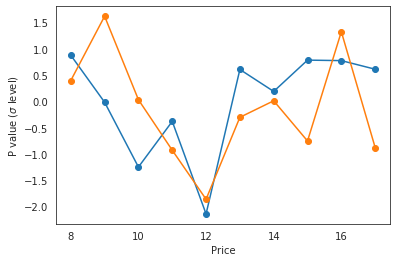

In [61]:
plt.plot(np.unique(fit_infer.data['price'].values),pvalues.T,'o-');
plt.xlabel('Price');
plt.ylabel('P value ($\sigma$ level)');

Note that this looks very similar to the residual plot. They are affectively looking at the same question, how good is the model compared to data. I prefer the Bayesian P values as it is using the full power of the posterior to do the comparison and as such it tends to be more robust and less noisy.

#### Other interesting questions

**$P(c_8 > c_0)$**

This plot investigates that preference a bit further. We can plot the samples from the posterior distributions for $c_0$ and $c_8$ against each other. The red line is the one to one line. For points above the line, $c_8$ is greater than $c_0$, for points below, $c_0$ is greater than $c_8$. By counting the number of points above the line, we can work out $P(c_8 > c_0)$. Interestingly, the number of points seems less than we might expect by looking at the histogram. This is due to the correlation between the two slopes, i.e. as one goes up, so does the other.

Text(0, 0.5, '$c_{8}$')

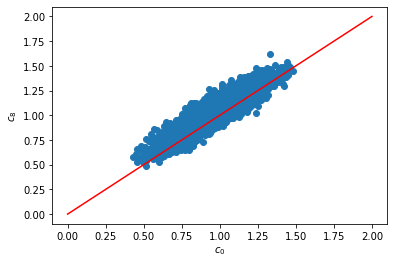

In [46]:
plt.scatter(fit_infer['c'][:,0],fit_infer['c'][:,8])
plt.plot(np.arange(0,3),np.arange(0,3),'r')
plt.xlabel(r'$c_{0}$')
plt.ylabel(r'$c_{8}$')

In [47]:
ind=fit_infer['c'][:,0]<fit_infer['c'][:,8]
print(r'P(c_8 > c_0) = {:6.4f}'.format(ind.sum()/fit_infer['c'].shape[0]))

P(c_8 > c_0) = 0.8013


## Fit to other products